## 알츠하이머 엑스레이 사진 분류 프로젝트

### 사용 데이터셋
- 데이터셋 링크
    - 캐글: https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset/data
    - 허깅페이스: https://huggingface.co/datasets/Falah/Alzheimer_MRI
- 흑백 사진
- 라벨
    - '0': Mild_Demented
    - '1': Moderate_Demented
    - '2': Non_Demented
    - '3': Very_Mild_Demented
- 이미지 데이터셋: 6,400개

## 사용 모델
- pytorch를 이용하여 직접 제작한 ResNet

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

In [ ]:
# Load the Falah/Alzheimer_MRI dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# Print the number of examples and the first few samples
print("Number of train examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Sample data:")
for example in train_dataset[:5]:
    print(example)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Number of train examples: 5120
Number of test examples: 1280
Sample data:
image
label


### Create DataLoader
- 팀원들과 맞춘 이미지 transforms
  - RGB 채널로 변환
  - ToTensor
  - 모델에 따라 Resize (안 해도 되면 기존 이미지 사이즈 128 x 128 그대로)

In [ ]:
class AlzheimerDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = data['image']  # Assuming 'image' field exists
        label = data['label']  # Assuming 'label' field exists
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.ToTensor()
])


- 팀원들과 맞춘 하이퍼 파라미터
  - batch size: 64
  - CrossEntropyLoss
  - Adam
  - learning rate: 3e-4
  - weight decay: 1e-3
  - epoch: 15

In [ ]:
train_data = AlzheimerDataset(train_dataset, transform=transform)
test_data = AlzheimerDataset(test_dataset, transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Modeling

In [ ]:
# Define the custom Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# Define the custom ResNet model
class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(CustomResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
# Instantiate model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = CustomResNet(ResidualBlock, [2, 2, 2, 2], num_classes=len(set(train_dataset['label']))) # ResNet-18
model = CustomResNet(ResidualBlock, [3, 4, 6, 3], num_classes=len(set(train_dataset['label']))) # ResNet-34
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

# Training loop
epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_f1_scores, test_f1_scores = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_f1_scores.append(train_f1)

    model.eval()
    running_loss = 0.0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_accuracies.append(test_accuracy)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    test_f1_scores.append(test_f1)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} - "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")

Epoch 1/15 - Train Loss: 0.8234, Train Acc: 0.6291, Train F1: 0.6208 - Test Loss: 1.2614, Test Acc: 0.6164, Test F1: 0.5990
Epoch 2/15 - Train Loss: 0.4983, Train Acc: 0.8078, Train F1: 0.8029 - Test Loss: 0.5059, Test Acc: 0.8063, Test F1: 0.8021
Epoch 3/15 - Train Loss: 0.2829, Train Acc: 0.8932, Train F1: 0.8913 - Test Loss: 1.1071, Test Acc: 0.5992, Test F1: 0.5594
Epoch 4/15 - Train Loss: 0.1717, Train Acc: 0.9391, Train F1: 0.9384 - Test Loss: 0.8981, Test Acc: 0.7250, Test F1: 0.7226
Epoch 5/15 - Train Loss: 0.1213, Train Acc: 0.9574, Train F1: 0.9574 - Test Loss: 1.7273, Test Acc: 0.5609, Test F1: 0.5655
Epoch 6/15 - Train Loss: 0.1005, Train Acc: 0.9656, Train F1: 0.9656 - Test Loss: 0.3785, Test Acc: 0.8922, Test F1: 0.8930
Epoch 7/15 - Train Loss: 0.0755, Train Acc: 0.9750, Train F1: 0.9750 - Test Loss: 0.3302, Test Acc: 0.9000, Test F1: 0.8946
Epoch 8/15 - Train Loss: 0.0610, Train Acc: 0.9809, Train F1: 0.9809 - Test Loss: 0.2468, Test Acc: 0.9156, Test F1: 0.9156
Epoch 9/

### Visualizations

- Plot Accuracy & Loss

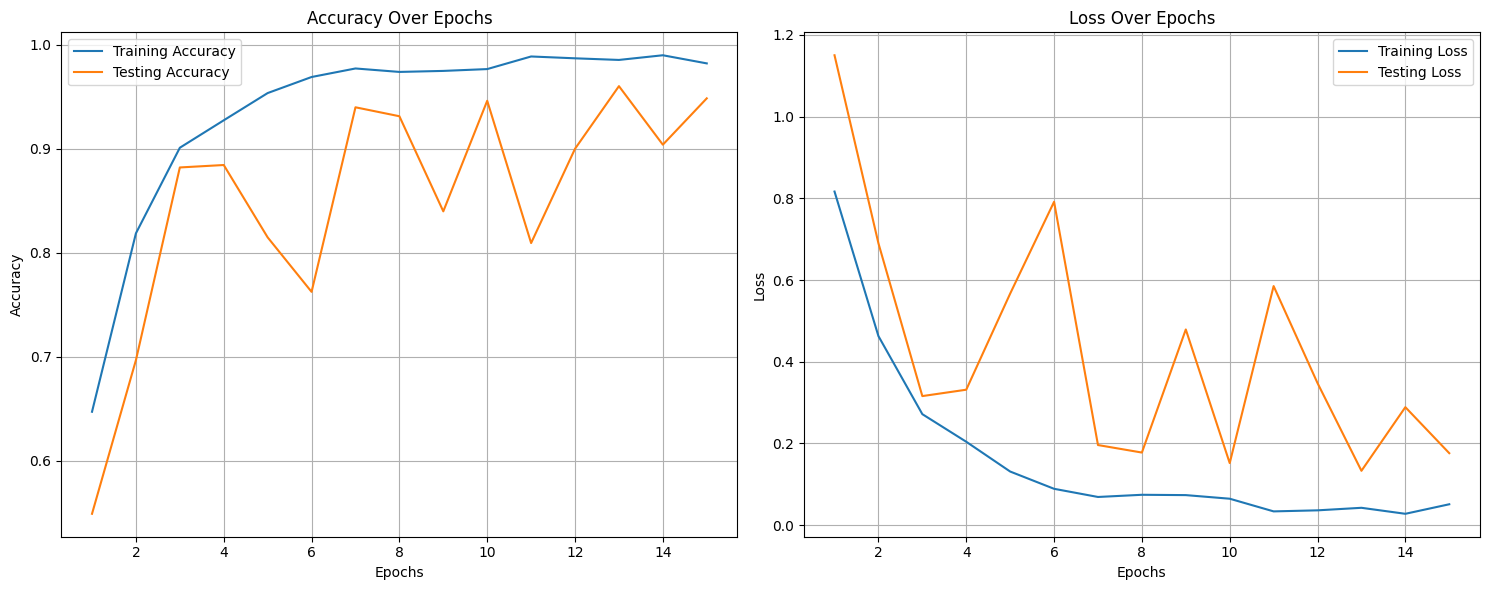

In [ ]:
import matplotlib.pyplot as plt

# 1행 2열 figure
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Accuracy
axs[0].plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
axs[0].plot(range(1, epochs + 1), test_accuracies, label="Testing Accuracy")
axs[0].set_title("Accuracy Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(range(1, epochs + 1), train_losses, label="Training Loss")
axs[1].plot(range(1, epochs + 1), test_losses, label="Testing Loss")
axs[1].set_title("Loss Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# 시각화
plt.tight_layout()
plt.show()


- Plot F1 score & Confusion Matrix

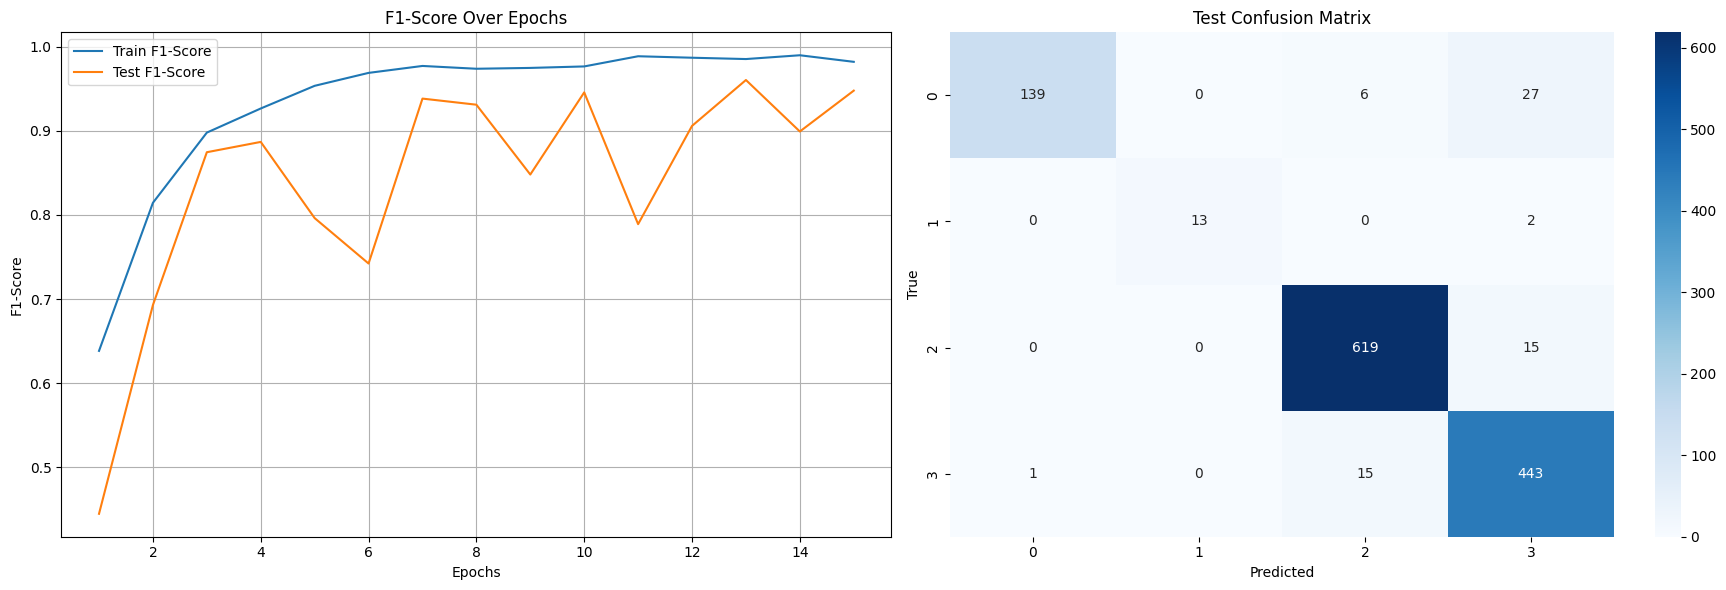

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1행 2열 figure
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot F1-Score
axs[0].plot(range(1, epochs + 1), train_f1_scores, label="Train F1-Score")
axs[0].plot(range(1, epochs + 1), test_f1_scores, label="Test F1-Score")
axs[0].set_title("F1-Score Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("F1-Score")
axs[0].legend()
axs[0].grid(True)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Test Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

# 시각화
plt.tight_layout()
plt.show()


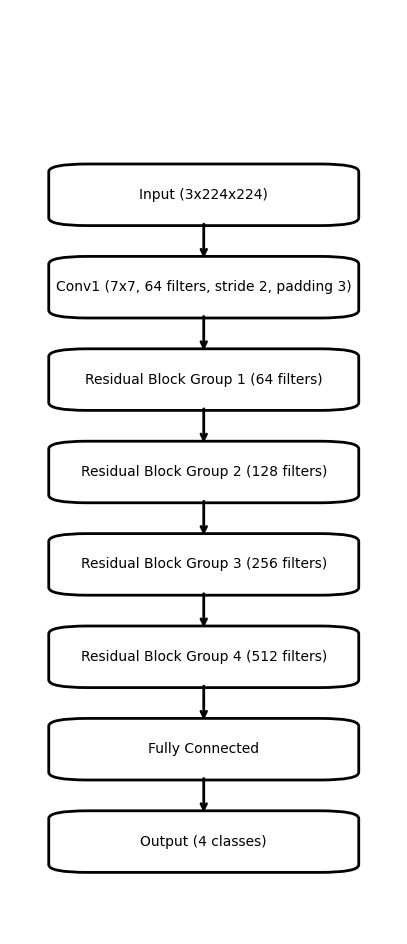

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_resnet_structure():
    fig, ax = plt.subplots(figsize=(5, 12))

    # 각 레이어의 이름을 아래에서 위로 나열된 리스트로 정의
    layers = [
        'Output (4 classes)',  # Output 클래스를 4로 변경
        'Fully Connected',
        'Residual Block Group 4 (512 filters)',
        'Residual Block Group 3 (256 filters)',
        'Residual Block Group 2 (128 filters)',
        'Residual Block Group 1 (64 filters)',
        'Conv1 (7x7, 64 filters, stride 2, padding 3)',
        'Input (3x224x224)'  # Input이 맨 위에 위치
    ]

    # 각 레이어의 위치 설정 (위에서 아래로 내려감)
    y_pos = [1.2+i*1.2 for i in range(len(layers))]

    # 박스 그리기 (레이어마다 사각형을 그림)
    for i, layer in enumerate(layers):
        ax.add_patch(patches.FancyBboxPatch((0.2, y_pos[i] - 0.3), 0.6, 0.6, boxstyle="round,pad=0.1", linewidth=2, edgecolor="black", facecolor="none"))
        ax.text(0.5, y_pos[i], layer, ha='center', va='center', fontsize=10, color='black')

    # 화살표 그리기 (각 레이어 간의 연결 화살표, 길이 줄이기)
    for i in range(len(layers) - 1):
        ax.annotate('', xy=(0.5, y_pos[i] + 0.2), xytext=(0.5, y_pos[i + 1] - 0.2),
                    arrowprops=dict(arrowstyle='->', lw=2, shrinkA=10, shrinkB=10))  # 화살표 방향 수정

    # 설정
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(layers) * 1.5)  # 여백을 줄이기 위해 범위 조정
    ax.axis('off')  # 축 제거
    plt.show()

# 실행
draw_resnet_structure()
